In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import itertools
import pickle

In [8]:
SIZE=299
CHANNEL=3
IMAGE_SHAPE=(SIZE, SIZE, CHANNEL)

BATCH_SIZE=4
EPOCHS=50

train_dir="D:/Datasets/Neutrophil-dataset/NeutrophilImages_split/neutrophil_train"
valid_dir="D:/Datasets/Neutrophil-dataset/NeutrophilImages_split/neutrophil_validiation"
test_dir="D:/Datasets/Neutrophil-dataset/NeutrophilImages_split/neutrophil_test"

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                   target_size=(SIZE, SIZE),
                                                   color_mode="rgb",
                                                   batch_size=BATCH_SIZE,
                                                   seed=19,
                                                   shuffle=True,
                                                   class_mode="categorical")

valid_datagen=ImageDataGenerator(rescale=1./255)
valid_generator=valid_datagen.flow_from_directory(valid_dir,
                                                  target_size=(SIZE, SIZE),
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  seed=19,
                                                  shuffle=True,
                                                  class_mode="categorical")

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(test_dir,
                                                  target_size=(SIZE, SIZE),
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  seed=19,
                                                  shuffle=True,
                                                  class_mode="categorical")

train_num=train_generator.samples
valid_num=valid_generator.samples

Found 157 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [6]:
#Instanciando modelo a partir de InceptionResNetV2

inception_model=InceptionResNetV2(input_shape=(299, 299, 3), weights='imagenet', include_top=False, classes=2)

for layer in inception_model.layers:
    layer.trainable=False

In [7]:
# Definindo o otimizador para compilar o modelo
OPT=Adam(learning_rate=1e-5) # learning_rate default = 0.001

# Adicionando novas camadas nas parte final do modelo
in_layer=Input(shape=IMAGE_SHAPE,dtype=tf.uint8)
x=tf.cast(in_layer, tf.float32)
x=preprocess_input(x)

x=inception_model(x, training=False)
x=GlobalAveragePooling2D()(x)
dense_layer=Dense(64, activation='relu', kernel_initializer='he_normal')(x)
drop_out=Dropout(0.4)(dense_layer)
out_layer=Dense(2, activation='softmax')(drop_out)


# Instanciando o modelo final com as devidas ateracoes
model=Model(inputs=in_layer, outputs=out_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=OPT, 
              metrics=['accuracy'])

In [9]:
model.fit_generator(train_generator,
                   epochs=EPOCHS,
                   steps_per_epoch=train_num // BATCH_SIZE,
                   validation_data=valid_generator,
                   validation_steps=valid_num // BATCH_SIZE)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
39/39 [==============================] - 13s 323ms/step - loss: 0.7332 - accuracy: 0.5229 - val_loss: 0.6871 - val_accuracy: 0.5500
Epoch 2/50
39/39 [==============================] - 6s 141ms/step - loss: 0.7064 - accuracy: 0.5621 - val_loss: 0.6237 - val_accuracy: 0.5500
Epoch 3/50
39/39 [==============================] - 5s 140ms/step - loss: 0.7043 - accuracy: 0.4967 - val_loss: 0.5661 - val_accuracy: 0.5500
Epoch 4/50
39/39 [==============================] - 6s 143ms/step - loss: 0.6023 - accuracy: 0.6154 - val_loss: 0.5182 - val_accuracy: 0.5500
Epoch 5/50
39/39 [==============================] - 6s 141ms/step - loss: 0.5365 - accuracy: 0.7190 - val_loss: 0.4739 - val_accuracy: 0.9500
Epoch 6/50
39/39 [==============================] - 6s 144ms/step - loss: 0.5196 - accuracy: 0.7386 - val_loss: 0.4374 - val_accuracy: 1.0000
Epoch 7/50
39/39 [==============================] - 6s 142ms/step - los

In [10]:
# Avaliacoes sobre o modelo

# Tendo acesso ao "ground truth" do dataset para teste
y_true=test_generator.labels

# Prevendo a propabilidade da distribuicao do dataset
prediction=model.predict(test_generator, verbose=1)

# Pegando a classe com maior probabilidade para cada exemplo
y_pred=np.argmax(prediction, axis=1)

# Gerando o relatorio de classificacao
print(classification_report(y_true, y_pred, target_names=['N1', 'N2']))

5/5 [==============================] - 1s 155ms/step
              precision    recall  f1-score   support

          N1       0.64      0.64      0.64        11
          N2       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



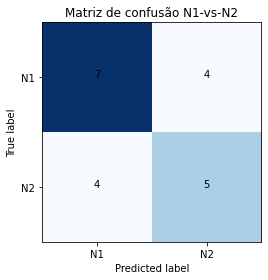

In [11]:
# Elaborando plot para matriz de confusão
class_names=['N1', 'N2']
cm=confusion_matrix(y_true, y_pred)
title="Matriz de confusão N1-vs-N2"
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks=np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
thresh=cm.max()/2

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="black")
             #color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [14]:
'''
pickle_out = open("model.pkl","wb")
pickle.dump(model, pickle_out)
pickle_out.close()
'''

model.save('neut_classifier.h5')